In [1]:
import numpy as np
import pandas as pd
from SWMM import SWMM_ENV as SWMM_ENV
from HC import HC as HC
import datetime
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import os
import yaml

import datetime

from MPC import pso
import pyswmm
from swmm_api.input_file import read_inp_file
from pyswmm import Simulation,Links,Nodes,RainGages,SystemStats
from swmm_api.input_file.sections.others import TimeseriesData
from swmm_api.input_file.sections import Control
from swmm_api.input_file.section_labels import TIMESERIES, CONTROLS
from swmm_api import read_rpt_file, SwmmReport

# Rainfall

In [2]:
rain1 = np.load('rainfall\\real_rainfall\\rain1.npy').tolist()
rain2 = np.load('rainfall\\real_rainfall\\rain2.npy').tolist()
rain3 = np.load('rainfall\\real_rainfall\\rain3.npy').tolist()
rain4 = np.load('rainfall\\real_rainfall\\rain4.npy').tolist()
raindata={'1':rain1, '2':rain2, '3':rain3, '4':rain4} #four rainuages

In [3]:
test_rainfall_id = [10,20,30,40,50,55,60,65,70,80]
np.save('./rainfall/testRainID.npy',test_rainfall_id)

test_rainfall_id = np.load('./rainfall/testRainID.npy',allow_pickle=True).tolist()
print(test_rainfall_id)

[10, 20, 30, 40, 50, 55, 60, 65, 70, 80]


# 寻优使用模型，给定降雨，带入swmm，最优化调整全程控制

## 优化计算使用函数

In [4]:
def step_results(sim,config,params,results):
    
    #获取模拟结果
    nodes = Nodes(sim)
    links = Links(sim)
    rgs = RainGages(sim)
    sys = SystemStats(sim)

    #obtain states and reward term by yaml (config)
    states = []
    for _temp in config["states"]:
        if _temp[1] == 'depthN':
            states.append(nodes[_temp[0]].depth)
        elif _temp[1] == 'flow':
            states.append(links[_temp[0]].flow)
        elif _temp[1] == 'inflow':
            states.append(nodes[_temp[0]].total_inflow)
        else:
            states.append(rgs[_temp[0]].rainfall)
        
    #获取reward和结果
    results, reward = SWMM_ENV.get_step_results(results,nodes,links,rgs,sys,config,params)
    results['state'].append(states)
    results['rewards'].append(reward)
    #results['action'].append(action)
      
    return states,reward,results

def trans_action(data):    
    ts = []
    for i in range(len(data)):
        t = i
        key = '01/01/2000 '+str(8+t*5//60).zfill(2)+':'+str((t*5) % 60).zfill(2)+':'+'00'
        ts.append([key,data[i]])
    return ts

In [5]:
class PSO(object):
    def __init__(self, population_size, 
                       max_steps, 
                       calculate_fitness,
                       control_d, w, c,
                       x_bound,
                       rainid,rainname,config,env_params,pop_param):
        self.w = w  # 惯性权重
        self.c1 = self.c2 = c  # 加速常数
        self.population_size = population_size  # 粒子群数量
        self.dim = control_d  # 搜索空间的维度
        self.max_steps = max_steps  # 迭代次数
        #self.x_bound = [-1, 1]  # 解空间范围
        # 使用上一时刻数据限定解空间范围
        self.x_bound = x_bound
        self.x = np.random.randint(0,self.x_bound,
                                   (self.population_size, self.dim))  # 初始化粒子群位置
        self.v = np.random.rand(self.population_size, self.dim)  # 初始化粒子群速度

        self.calculate_fitness=calculate_fitness
        self.rainid, self.rainname, self.config, self.env_params, self.pop_param = rainid, rainname,config,env_params,pop_param
        fitness = np.array(self.calculate_fitness(self.x,
                                             self.rainid,
                                             self.rainname,
                                             self.config,
                                             self.env_params,
                                             self.pop_param))
        self.p = self.x.copy()  # 个体的最佳位置
        self.pg = self.x[np.argmax(fitness)]  # 全局最佳位置
        self.individual_best_fitness = fitness  # 个体的最优适应度
        self.global_best_fitness = np.max(fitness)  # 全局最佳适应度

    def evolve(self):
        self.best_fit_curv=[]
        for step in range(self.max_steps):
            r1 = np.random.rand(self.population_size,self.dim)
            r2 = np.random.rand(self.population_size,self.dim)
            # 更新速度和权重
            self.v = self.w * self.v + self.c1 * r1 * (self.p - self.x) + self.c2 * r2 * (self.pg - self.x)
            self.x = np.int16(np.round(np.clip(self.v[0] + self.x, 0, self.x_bound)))
            fitness = np.array(self.calculate_fitness(self.x,
                                             self.rainid,
                                             self.rainname,
                                             self.config,
                                             self.env_params,
                                             self.pop_param))
            # 需要更新的个体
            update_id = np.greater(fitness,self.individual_best_fitness)
            self.p[update_id] = self.x[update_id]
            self.individual_best_fitness[update_id] = fitness[update_id]
            # 新一代出现了更大的fitness，所以更新全局最优fitness和位置
            if np.max(fitness)> self.global_best_fitness:
                self.pg = self.x[np.argmax(fitness)]    
                self.global_best_fitness = np.max(fitness)
            self.best_fit_curv.append(self.global_best_fitness)
            
            #渐进终止条件
            if step>50:
                if np.sum(self.best_fit_curv[-10:])-np.sum(self.best_fit_curv[-20:-10])<0.00001:
                    break
        np.save('./OPT_results/opt_curve_'+self.rainname+str(self.rainid),self.best_fit_curv)

In [6]:
def calobjValue_mp(actions_set,rainid,rainname,config,env_params,pop_param):
    action_table = pd.read_csv(os.getcwd()+'\\SWMM\\action_table.csv').values[:,1:]

    def interact(at,coreid,rainid,rainname,config,env_params):

        results = {'CSO':[0], 
            'flooding':[0], 
            'inflow':[0],
            'total_flooding_time':[0], 
            'total_CSO_time':[0],
            'res':[0],
            'state':[0],
            'action':[0], 
            'rewards':[0],
            'rewardSs':[0]
        }
        
        # 带有降雨和coreid的inp
        inp = read_inp_file('./SWMM/_temopt_original/chaohu_core' + str(coreid) + '_' + rainname + str(rainid)+'.inp')
        # action转化为inp使用的action，action放入SWMM（mp）
        ta={}
        for i in range(6):
            ta['pump'+str(i)] = []
            for t in at:
                pump_action = action_table[t].tolist()
                ta['pump'+str(i)].append(pump_action[i])
            inp[TIMESERIES]['pump'+str(i)]=TimeseriesData('pump'+str(i),trans_action(ta['pump'+str(i)]))
        
        inp.write_file('./SWMM/_temopt/chaohu_core' + str(coreid) + '_' + rainname + str(rainid)+'.inp')
        sim_tem = Simulation('./SWMM/_temopt/chaohu_core' + str(coreid) + '_' + rainname + str(rainid)+'.inp')
        # 读取模拟
        sim_tem.start()
        for step in range(95):
            sim_tem._model.swmm_stride(env_params['advance_seconds'])
            states,reward,results = step_results(sim_tem,config,env_params,results)
        sim_tem._model.swmm_end()
        sim_tem._model.swmm_close()
        # 统计评分
        reward = np.sum(results['rewards'])
        return reward
    
    obj_value = Parallel(n_jobs=pop_param['pop_size'])(delayed(interact)(actions_set[i],i,rainid,rainname,config,env_params) for i in range(len(actions_set)))
    #obj_value = []
    #print(actions_set[0])
    #for i in range(pop_param['pop_size']):
    #    obj_value.append(interact(actions_set[:,i],i,rainid,rainname,config,env_params))
    return obj_value


def opt(rainid,rainname,pop_param,config,env_params):
    pso_obj = PSO(pop_param['pop_size'],
                  pop_param['optstep'],
                  calobjValue_mp,
                  95,0.6,0.5,
                  pop_param['max_value'],
                  rainid,rainname,config,env_params,pop_param)

    pso_obj.evolve()
    best_individual, best_fit = pso_obj.pg, pso_obj.global_best_fitness
    return best_individual, best_fit

In [7]:
def save_actionOPT(best_individual):
    action = []
    action_table = pd.read_csv(os.getcwd()+'\\SWMM\\action_table.csv').values[:,1:]
    for it in best_individual:
        action.append(action_table[it].tolist())
    
    return action

In [8]:
class MPC_sim:

    def __init__(self,rainid,rainname,env_params,pop_param,config):
        self.rainid,self.rainname = rainid, rainname
        self.action_table = pd.read_csv(os.getcwd()+'\\SWMM\\action_table.csv').values[:,1:]
        self.env_params = env_params
        self.pop_param = pop_param
        self.config = config
    
    def reset(self,rules):
        # 初始化
        inp = read_inp_file('./SWMM/Astlingen_SWMM.inp')
        #加入降雨
        for i in range(1,5):
            inp[TIMESERIES]['rainfall'+str(i)]=TimeseriesData('rainfall'+str(i),raindata[str(i)][self.rainid])

        #加入控制title
        control_section = Control.create_section(rules)
        inp[CONTROLS]=control_section
        # 用于优化的inp
        for coreid in range(15):
            inp.write_file('./SWMM/_temopt_original/chaohu_core' + str(coreid) + '_' + self.rainname + str(self.rainid)+'.inp')
        
        # 用于最终模拟的inp
        inp.write_file('./SWMM/_temopt_original/chaohu_' + self.rainname + str(self.rainid)+'.inp')


    def opt_mp(self):
        # 读取模型开始优化调整action
        best_individual, best_fit = opt(self.rainid,self.rainname,self.pop_param,self.config,self.env_params)

        # 输出带action的input，并模拟，并保存结果
        # 带有降雨和coreid的inp
        inp = read_inp_file('./SWMM/_temopt_original/chaohu_' + self.rainname + str(self.rainid)+'.inp')
        # action转化为inp使用的action，action放入SWMM（mp）
        ta={}
        for i in range(6):
            ta['pump'+str(i)] = []
            for t in best_individual:
                pump_action = self.action_table[t].tolist()
                ta['pump'+str(i)].append(pump_action[i])
        for i in range(6):
            inp[TIMESERIES]['pump'+str(i)]=TimeseriesData('pump'+str(i),trans_action(ta['pump'+str(i)]))
        
        inp.write_file('./SWMM/_temopt_original/Sim_chaohu_'+self.rainname+str(self.rainid)+'.inp')
        # 读取模拟,获取评分结果
        results = {'CSO':[0], 
            'flooding':[0], 
            'inflow':[0],
            'total_flooding_time':[0], 
            'total_CSO_time':[0],
            'res':[0],
            'state':[0],
            'action':[0], 
            'rewards':[0],
            'rewardSs':[0]
        }
        sim_tem = Simulation('./SWMM/_temopt_original/Sim_chaohu_'+self.rainname+str(self.rainid)+'.inp')
        sim_tem.start()
        for step in range(95):
            sim_tem._model.swmm_stride(self.env_params['advance_seconds'])
            states,reward,results = step_results(sim_tem,self.config,self.env_params,results)
        results['action']=save_actionOPT(best_individual)
        sim_tem._model.swmm_end()
        sim_tem._model.swmm_close()

        return results

## 相关参数与控制设置

In [9]:
rules = """
RULE R0
IF SIMULATION TIME > 0
THEN ORIFICE V1 SETTING = TIMESERIES pump0

RULE R1
IF SIMULATION TIME > 0
THEN ORIFICE V2 SETTING = TIMESERIES pump1

RULE R2
IF SIMULATION TIME > 0
THEN ORIFICE V3 SETTING = TIMESERIES pump2

RULE R3
IF SIMULATION TIME > 0
THEN ORIFICE V4 SETTING = TIMESERIES pump3

RULE R4
IF SIMULATION TIME > 0
THEN ORIFICE V5 SETTING = TIMESERIES pump4

RULE R5
IF SIMULATION TIME > 0
THEN ORIFICE V6 SETTING = TIMESERIES pump5
"""

In [16]:
# env参数
st = 'SWMM\\Astlingen'

env_params = {
    'orf':st,
    'orf_save':'Astlingen_RTC',# opt中使用不同的inp计算，上两个参数没有用到
    'parm':'states_yaml\\Astlingen',
    'advance_seconds':300,
    'kf':1,
    'kc':1,
    'reward_type':'3',
}
config = yaml.load(open(env_params['parm']+".yaml"), yaml.FullLoader)

# pop优化算法参数
pop_param = {
    'pop_size':15,
    'max_value':15,
    'pc':0.6,
    'pm':0.5,
    'optstep':1000,
}
action_table = pd.read_csv(os.getcwd()+'\\SWMM\\action_table.csv').values[:,1:].tolist()

## Test

In [17]:
for i in range(90):
    print(i)
    optsys = MPC_sim(i,'design',env_params,pop_param,config)
    optsys.reset(rules)
    results = optsys.opt_mp()
    np.save('./OPT_results/opt_results_rain'+str(i),results)

0
1
2
3
4
5
6
7
8


d:\Anaconda\envs\tensorflow-cpu\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
d:\Anaconda\envs\tensorflow-cpu\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


9
10
11
12
13
14
15
16
17


d:\Anaconda\envs\tensorflow-cpu\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


18
19
20
21
22
23
24
25
26


d:\Anaconda\envs\tensorflow-cpu\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
d:\Anaconda\envs\tensorflow-cpu\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


27
28
29
30
31
32
33
34


d:\Anaconda\envs\tensorflow-cpu\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62


d:\Anaconda\envs\tensorflow-cpu\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
d:\Anaconda\envs\tensorflow-cpu\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
d:\Anaconda\envs\tensorflow-cpu\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


63
64
65
66
67
68
69
70


d:\Anaconda\envs\tensorflow-cpu\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
d:\Anaconda\envs\tensorflow-cpu\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


71
72
73
74
75
76
77
78
79


d:\Anaconda\envs\tensorflow-cpu\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
d:\Anaconda\envs\tensorflow-cpu\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


80
81
82
83
84
85
86
87
88


d:\Anaconda\envs\tensorflow-cpu\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


89


# Benchmark BC control

In [28]:
def save_BCaction(state):
    action = []
    for s in state:
        atem=[1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
        if s[0] >= 0:
            atem[1] = 0.2366
            atem[2] = 0.6508
            atem[3] = 0.3523
            atem[5] = 0.4303
        action.append(atem)

    return action

In [29]:
class BC_sim:

    def __init__(self,rainid,rainname,env_params,pop_param,config):
        self.rainid,self.rainname = rainid, rainname
        self.action_table = pd.read_csv(os.getcwd()+'\\SWMM\\action_table.csv').values[:,1:]
        self.env_params = env_params
        self.pop_param = pop_param
        self.config = config
    
    def reset(self):
        # 初始化
        inp = read_inp_file('./SWMM/Astlingen_SWMM.inp')
        #加入降雨
        for i in range(1,5):
            inp[TIMESERIES]['rainfall'+str(i)]=TimeseriesData('rainfall'+str(i),raindata[str(i)][self.rainid])
        
        # 用于最终模拟的inp
        inp.write_file('./SWMM/_temopt_original/BC/Astlingen_BC_' + self.rainname + str(self.rainid)+'.inp')


    def opt_mp(self):
        # 读取模型开始优化调整action
        # 读取模拟,获取评分结果
        results = {'CSO':[0], 
            'flooding':[0], 
            'inflow':[0],
            'total_flooding_time':[0], 
            'total_CSO_time':[0],
            'res':[0],
            'state':[0],
            'action':[0], 
            'rewards':[0],
            'rewardSs':[0]
        }
        sim_tem = Simulation('./SWMM/_temopt_original/BC/Astlingen_BC_'+self.rainname+str(self.rainid)+'.inp')
        sim_tem.start()
        for step in range(95):
            sim_tem._model.swmm_stride(self.env_params['advance_seconds'])
            states,reward,results = step_results(sim_tem,self.config,self.env_params,results)
        results['action']=save_BCaction(results['state'][1:])#BC记录T1水位反推action
        sim_tem._model.swmm_end()
        sim_tem._model.swmm_close()

        return results

In [30]:
for i in range(91):
    optsys = BC_sim(i,'design',env_params,pop_param,config)
    optsys.reset()
    results = optsys.opt_mp()
    np.save('./BC_results/bc_results_rain'+str(i),results)

# Benchmark EFD control

In [25]:
def save_EFDaction(states):
    action = []
    for state in states:
        atem=[1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
        if (state[1] < 1) and (state[2] < 1) and (state[3] < 1) and (state[5] < 1):
            atem[1] = 0.2366
            atem[2] = 0.6508
            atem[3] = 0.3523
            atem[5] = 0.4303

        if (state[1] > state[2]) and (state[1] > state[3]) and (state[1] > state[5]):
            atem[1] = 1
        else:
            atem[1] = 0.2366

        if (state[2] > state[1]) and (state[2] > state[3]) and (state[2] > state[5]):
            atem[2] = 1
        else:
            atem[2] = 0.6508

        if (state[3] > state[1]) and (state[3] > state[2]) and (state[3] > state[5]):
            atem[3] = 1
        else:
            atem[3] = 0.3523

        if (state[5] > state[1]) and (state[5] > state[2]) and (state[5] > state[5]):
            atem[5] = 1
        else:
            atem[5] = 0.4303

        if (state[1] < state[2]) and (state[1] < state[3]) and (state[1] < state[5]):
            atem[1] = 0.1075
        else:
            atem[1] = 0.2366

        if (state[2] < state[1]) and (state[2] < state[3]) and (state[2] < state[5]):
            atem[2] = 0.3159
        else:
            atem[2] = 0.6508
        
        if (state[3] < state[1]) and (state[3] < state[2]) and (state[3] < state[5]):
            atem[2] = 0.1894
        else:
            atem[2] = 0.3523

        if (state[5] < state[1]) and (state[5] < state[2]) and (state[5] < state[3]):
            atem[2] = 0.1687
        else:
            atem[2] = 0.4303

        action.append(atem)

    return action

In [26]:
class EFD_sim:

    def __init__(self,rainid,rainname,env_params,pop_param,config):
        self.rainid,self.rainname = rainid, rainname
        self.action_table = pd.read_csv(os.getcwd()+'\\SWMM\\action_table.csv').values[:,1:]
        self.env_params = env_params
        self.pop_param = pop_param
        self.config = config
    
    def reset(self):
        # 初始化
        inp = read_inp_file('./SWMM/EFD_Astlingen_SWMM.inp')
        #加入降雨
        for i in range(1,5):
            inp[TIMESERIES]['rainfall'+str(i)]=TimeseriesData('rainfall'+str(i),raindata[str(i)][self.rainid])
        # 用于最终模拟的inp
        inp.write_file('./SWMM/_temopt_original/EFD/chaohu_EFD_' + self.rainname + str(self.rainid)+'.inp')

    def opt_mp(self):
        # 读取模型开始优化调整action
        # 读取模拟,获取评分结果
        results = {'CSO':[0], 
            'flooding':[0], 
            'inflow':[0],
            'total_flooding_time':[0], 
            'total_CSO_time':[0],
            'res':[0],
            'state':[0],
            'action':[0], 
            'rewards':[0],
            'rewardSs':[0]
        }
        sim_tem = Simulation('./SWMM/_temopt_original/EFD/chaohu_EFD_'+self.rainname+str(self.rainid)+'.inp')
        sim_tem.start()
        for step in range(95):
            sim_tem._model.swmm_stride(self.env_params['advance_seconds'])
            states,reward,results = step_results(sim_tem,self.config,self.env_params,results)
        results['action']=save_EFDaction(results['state'][1:])#EFD记录T1水位反推action
        sim_tem._model.swmm_end()
        sim_tem._model.swmm_close()

        return results

In [27]:
for i in range(91):
    optsys = EFD_sim(i,'design',env_params,pop_param,config)
    optsys.reset()
    results = optsys.opt_mp()
    np.save('./EFD_results/efd_results_rain'+str(i),results)

# Compare

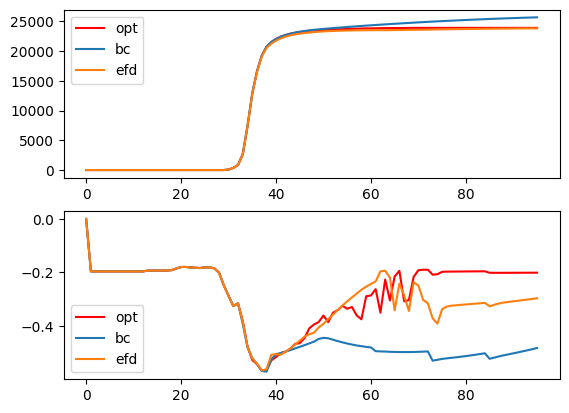

In [35]:
rainid = '61'
re = np.load('./OPT_results/opt_results_rain'+rainid+'.npy',allow_pickle=True).tolist()
reb = np.load('./BC_results/bc_results_rain'+rainid+'.npy',allow_pickle=True).tolist()
ree = np.load('./EFD_results/efd_results_rain'+rainid+'.npy',allow_pickle=True).tolist()
figs,ax = plt.subplots(2,1)
ax[0].plot(re['flooding'],'r',label='opt')
ax[0].plot(reb['flooding'],label='bc')
ax[0].plot(ree['flooding'],label='efd')
ax[0].legend()
ax[1].plot(re['rewards'],'r',label='opt')
ax[1].plot(reb['rewards'],label='bc')
ax[1].plot(ree['rewards'],label='efd')
ax[1].legend()